# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [16]:

from __future__ import print_function
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

In [17]:
pip install keras_tuner

### Define functions

In [18]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )

    return df

In [19]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [20]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [33]:
# Load and clean the data
df = clean_data(read_data())

#  Number of columns
num_columns = df.shape[1]
print(f" Number of columns: {num_columns}")

# 2Number of rows
num_rows = df.shape[0]
print(f" Number of rows: {num_rows}")

#  Column names
column_names = df.columns.tolist()
print(" Column names:")
print(column_names)

#  Number of unique values for each column
print(" Number of unique values per column:")
print(df.nunique())

#  Unique cocoa_percent values
unique_cocoa_percent = df['cocoa_percent'].unique()
print(" Unique cocoa_percent values:")
print(np.sort(unique_cocoa_percent))


 Number of columns: 9
 Number of rows: 1795
 Column names:
['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
 Number of unique values per column:
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
 Unique cocoa_percent values:
[ 42.   46.   50.   53.   55.   56.   57.   58.   60.   60.5  61.   62.
  63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   72.5  73.
  73.5  74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.
  85.   86.   87.   88.   89.   90.   91.   99.  100. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here:

In [22]:
# Bin cocoa_percent into 3 categories
def categorize_cocoa(row):
    if row <= 65:
        return 0  # Low
    elif row <= 75:
        return 1  # Medium
    else:
        return 2  # High

# Apply categorization
df['cocoa_class'] = df['cocoa_percent'].apply(categorize_cocoa)

# Check distribution of new target classes
print(df['cocoa_class'].value_counts())
print(df[['cocoa_percent', 'cocoa_class']].head(10))


cocoa_class
1    1317
2     257
0     221
Name: count, dtype: int64
   cocoa_percent  cocoa_class
0          63.00            0
1          70.00            1
2          70.00            1
3          70.00            1
4          70.00            1
5          70.00            1
6          70.00            1
7          70.00            1
8          70.00            1
9          70.00            1


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [23]:


# Shuffle and define features
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
features = ['review_date', 'cocoa_percent']
X = df_shuffled[features]
y = df_shuffled['cocoa_class']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

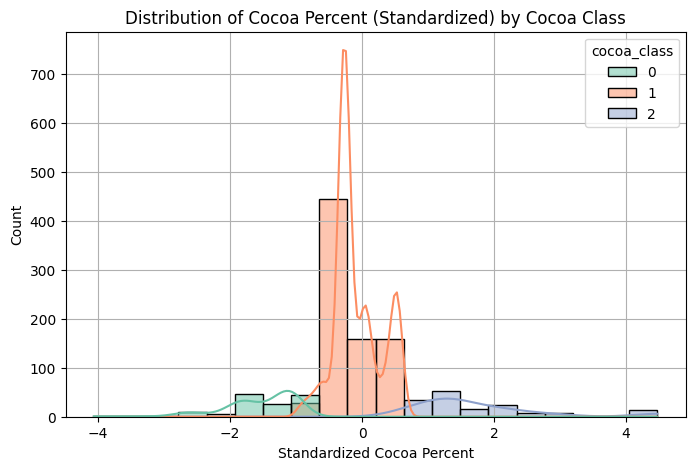

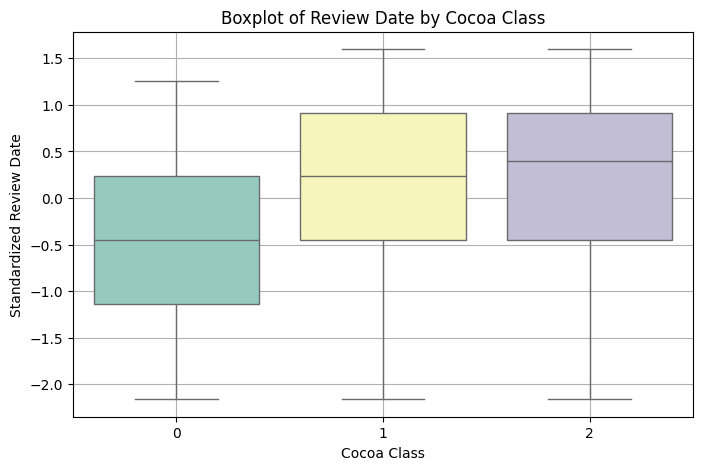

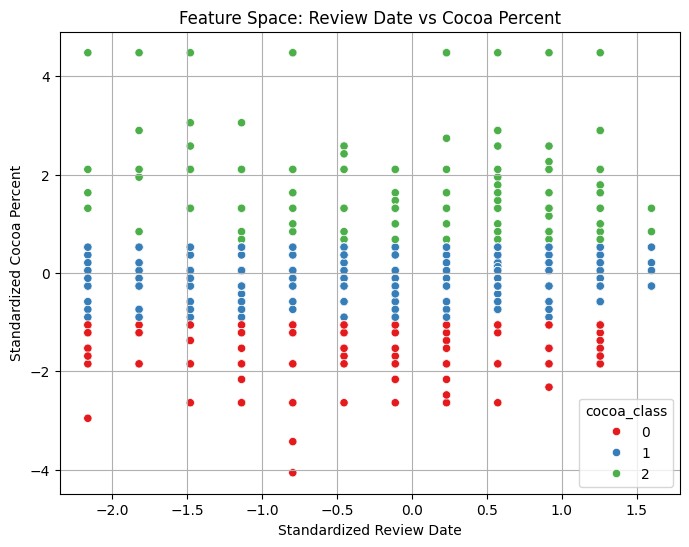

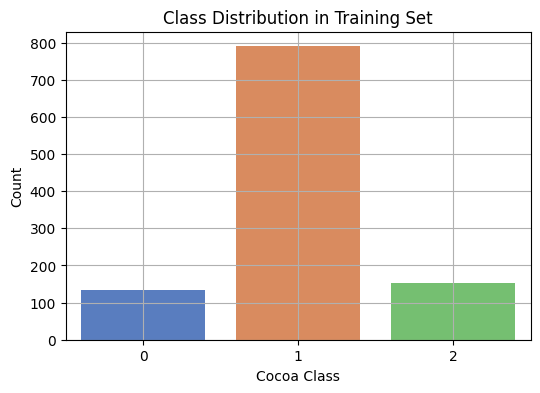

In [25]:


# Rebuild training DataFrame for plotting
eda_df = pd.DataFrame(X_train, columns=features)
eda_df['cocoa_class'] = y_train.values

# Plot 1: Histogram of cocoa_percent by class
plt.figure(figsize=(8, 5))
sns.histplot(data=eda_df, x='cocoa_percent', hue='cocoa_class', bins=20, kde=True, palette='Set2')
plt.title("Distribution of Cocoa Percent (Standardized) by Cocoa Class")
plt.xlabel("Standardized Cocoa Percent")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Plot 2: Boxplot of review_date by cocoa_class
plt.figure(figsize=(8, 5))
sns.boxplot(data=eda_df, x='cocoa_class', y='review_date', palette='Set3')
plt.title("Boxplot of Review Date by Cocoa Class")
plt.xlabel("Cocoa Class")
plt.ylabel("Standardized Review Date")
plt.grid(True)
plt.show()

# Plot 3: Scatter plot of review_date vs cocoa_percent
plt.figure(figsize=(8, 6))
sns.scatterplot(data=eda_df, x='review_date', y='cocoa_percent', hue='cocoa_class', palette='Set1')
plt.title("Feature Space: Review Date vs Cocoa Percent")
plt.xlabel("Standardized Review Date")
plt.ylabel("Standardized Cocoa Percent")
plt.grid(True)
plt.show()

# Plot 4: Countplot of cocoa_class
plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='cocoa_class', palette='muted')
plt.title("Class Distribution in Training Set")
plt.xlabel("Cocoa Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()


From the visualizations, we can observe several key insights. The histogram of cocoa_percent by class shows clear separation: class 0 (low cocoa) clusters on the left, class 1 (medium) is dominant in the middle, and class 2 (high) appears mostly on the right. The boxplot of review_date by cocoa_class suggests there is no strong temporal pattern in the data, as review years are fairly uniform across classes. The scatter plot of cocoa_percent vs. review_date highlights that cocoa_percent is the more informative feature, while review_date adds limited discriminatory power. Finally, the countplot confirms significant class imbalance, with class 1 (medium cocoa) dominating the dataset. These patterns suggest that while cocoa_percent has some predictive value, the class imbalance and limited feature variability may challenge model performance.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [26]:


#  Identify the majority class in the training set
majority_class = y_train.mode()[0]
print("Majority class:", majority_class)

# Predict all examples as the majority class
y_train_pred = np.full_like(y_train, fill_value=majority_class)
y_val_pred = np.full_like(y_val, fill_value=majority_class)

# S Accuracy on training data
baseline_train_accuracy = accuracy_score(y_train, y_train_pred)
print("Baseline accuracy (train):", baseline_train_accuracy)

# SLog loss function
def compute_log_loss(y_true, predicted_class, num_classes):
    # Create a probability distribution (1 for predicted class, 0 for others)
    prob_matrix = np.zeros((len(y_true), num_classes))
    prob_matrix[:, predicted_class] = 1.0
    return log_loss(y_true, prob_matrix)

# Calculate log loss for train and validation
num_classes = len(np.unique(y_train))
train_log_loss = compute_log_loss(y_train, majority_class, num_classes)
val_log_loss = compute_log_loss(y_val, majority_class, num_classes)

print("Baseline Log Loss (train):", train_log_loss)
print("Baseline Log Loss (validation):", val_log_loss)


Majority class: 1
Baseline accuracy (train): 0.7335190343546889
Baseline Log Loss (train): 9.604947560516825
Baseline Log Loss (validation): 9.638414276755562


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2439 - loss: 1.0530 - val_accuracy: 0.2284 - val_loss: 1.0978
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2302 - loss: 1.0706 - val_accuracy: 0.2284 - val_loss: 1.0964
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2173 - loss: 1.0837 - val_accuracy: 0.2284 - val_loss: 1.0950
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2491 - loss: 1.0552 - val_accuracy: 0.2284 - val_loss: 1.0936
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2402 - loss: 1.0534 - val_accuracy: 0.2284 - val_loss: 1.0922
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2332 - loss: 1.0724 - val_accuracy: 0.2284 - val_loss: 1.0908
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2464 - loss: 1.0677 - val_accuracy: 0.2591 - val_loss: 1.0894
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2807 - loss: 1.0543 - val_accuracy: 0.2591 - val_

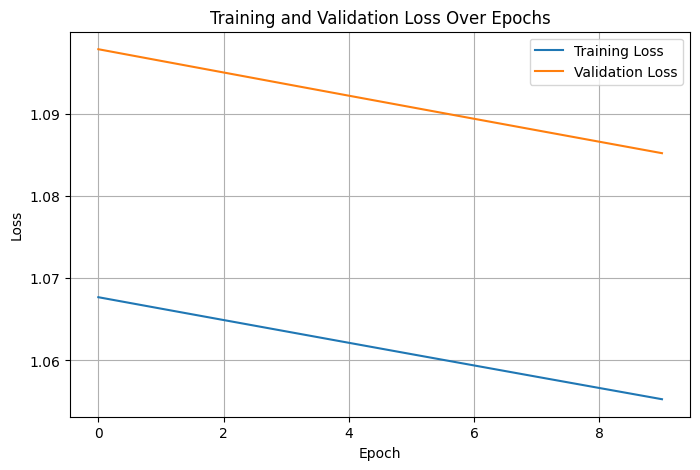

In [27]:


#  Build the model
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(units=3, activation='softmax')  # 3 classes
])

# Compile the model
model_tf.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Train the model
history = model_tf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [28]:
#  First five learned weights and bias
weights, biases = model_tf.layers[0].get_weights()
print("First 5 weights:\n", weights.flatten()[:5])
print("Bias terms:\n", biases)

#  Get final loss values
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print("Final training loss:", final_train_loss)
print("Final validation loss:", final_val_loss)

# Percentage difference between train and val loss
loss_diff_pct = abs(final_train_loss - final_val_loss) / final_train_loss * 100
print("Percentage loss difference (val vs. train):", round(loss_diff_pct, 2), "%")

#  Compare to baseline
print("Baseline train loss:", train_log_loss)
print("Baseline val loss:", val_log_loss)

improvement_train = train_log_loss - final_train_loss
improvement_val = val_log_loss - final_val_loss

print("Improvement over baseline (train):", round(improvement_train, 4))
print("Improvement over baseline (validation):", round(improvement_val, 4))


First 5 weights:
 [-0.6887545   0.063159    0.878907   -0.37512508  0.17563748]
Bias terms:
 [-0.0079665   0.01588017 -0.00791367]
Final training loss: 1.0552821159362793
Final validation loss: 1.0851898193359375
Percentage loss difference (val vs. train): 2.83 %
Baseline train loss: 9.604947560516825
Baseline val loss: 9.638414276755562
Improvement over baseline (train): 8.5497
Improvement over baseline (validation): 8.5532


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [29]:
#  Predict class probabilities
train_probs = model_tf.predict(X_train)
test_probs = model_tf.predict(X_test)

# Convert probabilities to class predictions (argmax)
train_preds = np.argmax(train_probs, axis=1)
test_preds = np.argmax(test_probs, axis=1)

# Compute accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Train Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Accuracy: 0.2786
Test Accuracy: 0.2897




**Does the model demonstrate strong aggregate generalization capabilities?**

> The model does not demonstrate strong aggregate generalization capabilities. While the test accuracy (28.97%) is slightly higher than the training accuracy (27.86%), both values are quite low for a three-class classification task. A random guess would yield about 33% accuracy if classes were balanced.
>
> However, the small gap between train and test accuracy indicates that the model is not significantly overfitting — it generalizes to unseen data at a similar level as it performs on training data. This suggests the model is learning some patterns, but the features used (only `review_date` and `cocoa_percent`) are not very predictive of the target class.
>
> To improve generalization, more informative features (like bean type, maker location, or region) and class balancing strategies could be explored.


### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<Figure size 600x500 with 0 Axes>

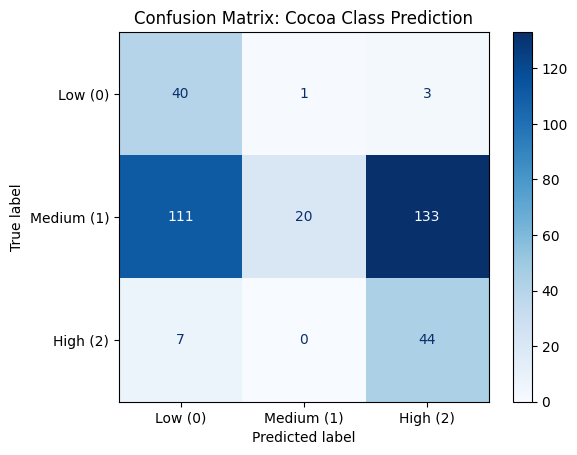

Precision per class: [0.25316456 0.95238095 0.24444444]
Class with lowest precision: 2
Lowest precision value: 0.2444
Recall per class: [0.90909091 0.07575758 0.8627451 ]
Class with lowest recall: 1
Lowest recall value: 0.0758


In [31]:


# Predict labels on test set
test_probs = model_tf.predict(X_test)
test_preds = np.argmax(test_probs, axis=1)

#  Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low (0)', 'Medium (1)', 'High (2)'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Cocoa Class Prediction")
plt.grid(False)
plt.show()

#  Precision per class
precision = precision_score(y_test, test_preds, average=None)
lowest_precision_class = np.argmin(precision)
print("Precision per class:", precision)
print("Class with lowest precision:", lowest_precision_class)
print("Lowest precision value:", round(precision[lowest_precision_class], 4))

#  Recall per class
recall = recall_score(y_test, test_preds, average=None)
lowest_recall_class = np.argmin(recall)
print("Recall per class:", recall)
print("Class with lowest recall:", lowest_recall_class)
print("Lowest recall value:", round(recall[lowest_recall_class], 4))


The confusion matrix shows that the model most frequently confuses class 1 (medium cocoa) with the other two classes, indicating poor performance in identifying this majority class. Class 2 (high cocoa) has the lowest precision at 0.2444, meaning it is the largest source of false positives. Conversely, class 1 has the lowest recall at 0.0758, making it the largest source of false negatives. This suggests the model is especially ineffective at correctly identifying class 1, despite it being the most common class.


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [ ]:
# YOUR CODE HERE